### LSE Data Analytics Online Career Accelerator 

# DA301:  Advanced Analytics for Organisational Impact

**Author:** Gavin van de Bunt <br>
**Date:** 09 January 2023

### Context
This analysis has been performed for Turtle Games, a game manufacturer and retailer. They manufacture and sell their own products, along with sourcing and selling products manufactured by other companies. Their product range includes books, board games, video games and toys. They have a global customer base and have a business objective of improving overall sales performance by utilising customer trends. <br><br>
In particular, this notebook describes analysis done in Python to help Turtle Games understand: 
- how customers accumulate loyalty points.
- how useful remuneration and spending scores data are.
- how social data (e.g. customer reviews) can be used in marketing campaigns.

A follow-up study, performed in R can be found in the same GitHub repository. This will focus on three remaining business questions:
- what is the impact on sales per product?
- what is the reliability of the data (e.g. normal distribution, Skewness, Kurtosis)?
- is there any possible relationship(s) in sales between North America, Europe, and global sales?

In addition to this Python notebook and the abovementioned R script, you can find a detailed report and accompanying presentation in the parent GitHub repository.

For any questions, please reach out to GavinvdBunt@Gmail.com

## 1. Load the necessary libraries, packages used in the analysis

Here all imports are done that are needed for the entire notebook.

In [1]:
# Import all the necessary packages.
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot

import sklearn
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter

from textblob import TextBlob

# To avoid unnecessary warnings not leading to errors.
import warnings  
warnings.filterwarnings('ignore') 

## 2. Import data set.

Here the data file is turned into a Pandas Dataframe. There is only one data set used for the entire notebook.

In [2]:
# Import the turtle reviews data.
reviews = pd.read_csv('turtle_reviews.csv')

## 3. Clean data set.

Generic preliminary analysis and cleansing of the data set is performed. Model specific data cleansing and preparation is done in the upcoming individual subsections.

In [3]:
# Sense-check the DataFrame by printing the DataFrame, data types and metadata.
print(reviews.head())
print(reviews.info())
print(reviews.describe())

# Determine if there are any missing values in the DataFrame.
reviews.isna().sum()

   gender  age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
0    Male   18              12.30                      39             210   
1    Male   23              12.30                      81             524   
2  Female   22              13.12                       6              40   
3  Female   25              13.12                      77             562   
4  Female   33              13.94                      40             366   

  education language platform  product  \
0  graduate       EN      Web      453   
1  graduate       EN      Web      466   
2  graduate       EN      Web      254   
3  graduate       EN      Web      263   
4  graduate       EN      Web      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  A

gender                    0
age                       0
remuneration (k£)         0
spending_score (1-100)    0
loyalty_points            0
education                 0
language                  0
platform                  0
product                   0
review                    0
summary                   0
dtype: int64

In [4]:
# Remove redundant columns (language and platform).
reviews.drop(['language', 'platform'], axis=1,inplace=True)

In [5]:
# Change column headings to names that are easier to reference.
reviews.rename(columns={
    'remuneration (k£)':'remuneration',
    'spending_score (1-100)':'spending_score'},inplace=True)
print(reviews.shape)
reviews.head(2)

(2000, 9)


,gender,age,remuneration,spending_score,loyalty_points,education,product,review,summary
0,Male,18,12.3,39,210,graduate,453,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...
1,Male,23,12.3,81,524,graduate,466,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...


## 4. Perform linear regression

The marketing department of Turtle Games prefers Python for data analysis. They have asked to assist with data analysis of their social media data. In particular, the marketing department wants to better understand how users accumulate loyalty points. Therefore, below code explores the possible relationships between the loyalty points, age, remuneration, and spending scores.

### 4.1 Prepare the data for regression.

Variables are assigned, the data set is further simplified and basic analysis is done.

In [6]:
## Specify the independent and dependent variables.

# Define the dependent variable as loyalty points.
y = reviews['loyalty_points']

# Define the independent variables as age, remuneration and spending score.
age = reviews['age']
remuneration = reviews['remuneration']
spend = reviews['spending_score']


,loyalty_points,age,remuneration,spending_score
loyalty_points,1.000000,-0.042445,0.616065,0.672310
age,-0.042445,1.000000,-0.005708,-0.224334
remuneration,0.616065,-0.005708,1.000000,0.005612
spending_score,0.672310,-0.224334,0.005612,1.000000


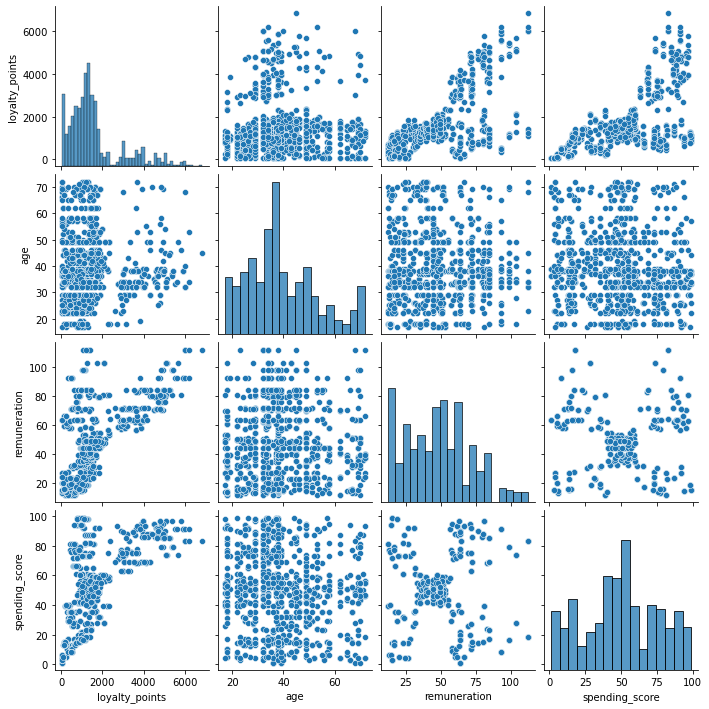

In [7]:
# Create pairplots to have a first look at the relationships.
pairplot = reviews[['loyalty_points','age','remuneration','spending_score']]

sns.pairplot(pairplot,
             vars=pairplot,
             diag_kind= 'hist')

# Check the correlation of the variables.
pairplot.corr()

### 4.1 Age

The first of the independent variables is explored: age. <br>

The model summary shows this variable has a very low explanatory value (R-squared) of 0.2% and is not statistically significant at a 0.05 confidence level (p>0.05). This is in line with what we could see from the pairplots and the correlation in the previous sector.<br>

Due to the above, we will drop this variable for our multiple regression model.

In [8]:
# Create formula and pass through OLS methods.
age_model = ols('y~age', data = reviews).fit()

# Print the regression table.
print(age_model.summary() )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.606
Date:                Sat, 07 Jan 2023   Prob (F-statistic):             0.0577
Time:                        23:20:08   Log-Likelihood:                -17150.
No. Observations:                2000   AIC:                         3.430e+04
Df Residuals:                    1998   BIC:                         3.431e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1736.5177     88.249     19.678      0.0

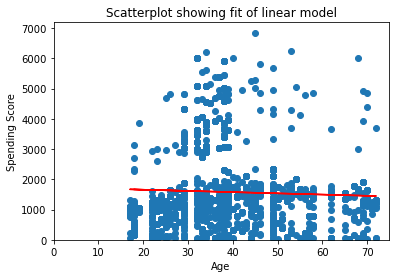

In [9]:
# Plot the data points with a scatterplot.
plt.scatter(age, y)

# Set the the coefficients from the created model.
y_age_pred = age_model.params[0] + age_model.params[1] * reviews['age']

# Plot the regression line (in red).
plt.plot(age, y_age_pred, color='red')

# Set the x and y limits on the axes.
plt.xlim(0)
plt.ylim(0)

# Add axis labels
plt.title('Scatterplot showing fit of linear model')
plt.xlabel('Age')
plt.ylabel('Spending Score')

# View the plot.
plt.show()

### 4.2 Remuneration

The second of the independent variables is explored: remuneration. <br>

The model summary shows this variable has an acceptable value (R-squared) and is statistically significant at a 0.05 confidence level (p<0.05). This is in line with what we could see from the pairplots and the correlation in the previous sector.<br>

We do see a diverging pattern when visualising the residuals. This will be further explored in the multiple linear regression model.

In [10]:
# Create formula and pass through OLS methods.
remuneration_model = ols('y~remuneration', data = reviews).fit()

# Print the regression table.
print(remuneration_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     1222.
Date:                Sat, 07 Jan 2023   Prob (F-statistic):          2.43e-209
Time:                        23:20:09   Log-Likelihood:                -16674.
No. Observations:                2000   AIC:                         3.335e+04
Df Residuals:                    1998   BIC:                         3.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -65.6865     52.171     -1.259   

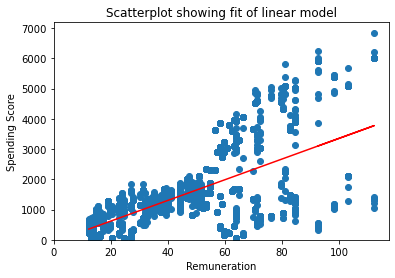

In [11]:
# Create a visual of the linear regression model.
# Plot the data points with a scatterplot.
plt.scatter(remuneration, y)

# Set the the coefficients from the created model.
y_remuneration_pred = remuneration_model.params[0] + remuneration_model.params[1] * reviews['remuneration']

# Plot the regression line (in red).
plt.plot(remuneration, y_remuneration_pred, color='red')

# Set the x and y limits on the axes.
plt.xlim(0)
plt.ylim(0)

# Add axis labels
plt.title('Scatterplot showing fit of linear model')
plt.xlabel('Remuneration')
plt.ylabel('Spending Score')

# View the plot.
plt.show()

Text(0, 0.5, 'Residuals on Loyalty Points')

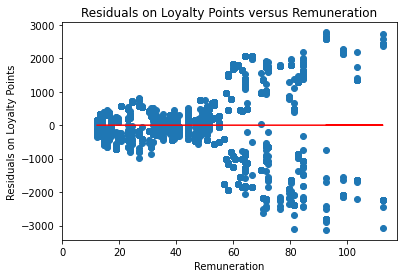

In [12]:
# Look at behaviour of residuals. There should be no pattern ideally.
remun_resids = y_remuneration_pred-reviews['loyalty_points']
plt.scatter(remuneration, remun_resids)
plt.plot(remuneration, reviews['loyalty_points']-reviews['loyalty_points'], color='red')

# Add axis labels
plt.xlim(0)
plt.title('Residuals on Loyalty Points versus Remuneration')
plt.xlabel('Remuneration')
plt.ylabel('Residuals on Loyalty Points')

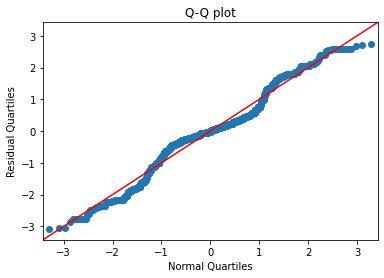

In [13]:
# Add QQplot to further visualize non-randomness of residuals.
sm.qqplot(remun_resids, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Q-Q plot")
plt.show()

### 4.3 Spending score

The third of the independent variables is explored: spending score. <br>

The model summary shows this variable has a good value (R-squared) of 45.2% and is statistically significant at a 0.05 confidence level (p<0.05). This is in line with what we could see from the pairplots and the correlation in the previous sector.<br>

We do again see a diverging pattern when visualising the residuals. This will be further explored in the multiple linear regression model.

In [14]:
# Create formula and pass through OLS methods.
spend_model = ols('y~spend', data = reviews).fit()

# Print the regression table.
print(spend_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     1648.
Date:                Sat, 07 Jan 2023   Prob (F-statistic):          2.92e-263
Time:                        23:20:09   Log-Likelihood:                -16550.
No. Observations:                2000   AIC:                         3.310e+04
Df Residuals:                    1998   BIC:                         3.312e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -75.0527     45.931     -1.634      0.1

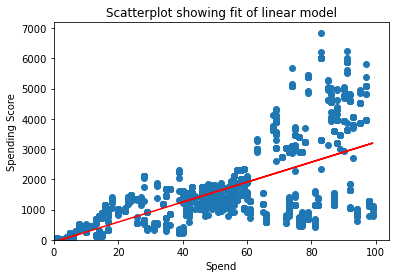

In [15]:
# Plot the data points with a scatterplot.
plt.scatter(spend, y)

# Set the the coefficients from the created model.
y_spend_pred = spend_model.params[0] + spend_model.params[1] * reviews['spending_score']

# Plot the regression line (in red).
plt.plot(spend, y_spend_pred, color='red')

# Set the x and y limits on the axes.
plt.xlim(0)
plt.ylim(0)

# Add axis labels
plt.title('Scatterplot showing fit of linear model')
plt.xlabel('Spend')
plt.ylabel('Spending Score')

# View the plot.
plt.show()

Text(0, 0.5, 'Residuals on Loyalty Points')

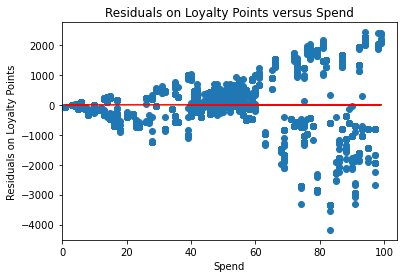

In [16]:
# Look at behaviour of residuals. There should be no pattern ideally.
spend_resids = y_spend_pred-reviews['loyalty_points']
plt.scatter(spend, spend_resids)
plt.plot(spend, reviews['loyalty_points']-reviews['loyalty_points'], color='red')

# Add axis labels
plt.xlim(0)
plt.title('Residuals on Loyalty Points versus Spend')
plt.xlabel('Spend')
plt.ylabel('Residuals on Loyalty Points')

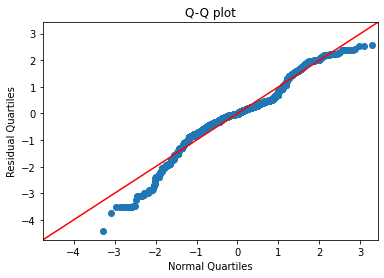

In [17]:
# Add QQplot to further visualize non-randomness of residuals.
sm.qqplot(spend_resids, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Q-Q plot")
plt.show()

### 4.4 Multiple linear regression

The multiple linear regression model created below uses two independent variables (remuneration and spending score) to predict the dependent variable: loyalty points. <br>

The data is split into a train (80%) and a test (20%) data set, and the model created with train data. After various iterations (commented out, but still available for future usage) it was decided it was necessary to perform a square root transformation on the y-variable as there was severe heteroskedacity in the standard model. <br>

This final model improves the R-squared on the test data set to a strong 89.2% score, including:
- Two very significant predictors in remuneration and spending score.
- No visible multicollinearity (VIF=1.0)
- Acceptance of hypothesis of Breusch-Pagan test and thus homoskedacity.

More on the findings and conclusions from the model can be found in the accompanying document/video in the GitHub repository.

In [18]:
# Create new variables for multiple regression including relevant independent variables.
X = reviews[['remuneration','spending_score']]

# For testing only, commented out by default: alternative model including age predictor (removed due to very low explanatory value).
# X = reviews[['age','remuneration','spending_score']]

# Final model: sqrt of dependent variable to minimize heterosckedacity and non-linearity
# Define the dependent variable.
# y = reviews['loyalty_points']
# y = np.log(reviews['loyalty_points'])
y = np.sqrt(reviews['loyalty_points'])

# Split the data in 'train' (80%) and 'test' (20%) sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, y,
                                                                            train_size = 0.80,
                                                                            random_state = 42)

In [19]:
# Training the model using the 'statsmodel' OLS library.
# Fit the model with the added constant.
model = sm.OLS(Y_train, sm.add_constant(X_train)).fit()

# Call a summary of the model.
print_model = model.summary()

# Print the summary.
print(print_model)  

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     6319.
Date:                Sat, 07 Jan 2023   Prob (F-statistic):               0.00
Time:                        23:20:09   Log-Likelihood:                -4909.8
No. Observations:                1600   AIC:                             9826.
Df Residuals:                    1597   BIC:                             9842.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.2610      0.389    -10.

In [20]:
# Specify the model.
mlr = LinearRegression()  

# Fit the model. We can only fit the model with the training data set.
mlr.fit(X_train, Y_train)  

LinearRegression()

In [21]:
# Print the R-squared value for the test data set to check the predictive power of the model.
print(mlr.score(X_test, Y_test)*100)  

89.23259059589131


In [22]:
# Check for multicollinearity.
# Add a constant.
x_temp = sm.add_constant(X_train)  

# Create an empty DataFrame. 
vif = pd.DataFrame() 

# Calculate the 'vif' for each value.
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, 
                                               i) for i in range(x_temp.values.shape[1])]  


# Create the feature columns.
vif['features'] = x_temp.columns  

# Print the values to two decimal points. Values above 10 indicate an issue of multicollinearity.
print(vif.round(2))  

   VIF Factor        features
0        8.91           const
1        1.00    remuneration
2        1.00  spending_score


In [23]:
# Find the MAE and MSE for the test data of the model.
# Set the predicted response vector.
Y_pred = model.predict(sm.add_constant(X_test)) 

# Call the ‘metrics.mean_absolute_error’ function.  
print('Mean Absolute Error (Final):', metrics.mean_absolute_error(Y_test, Y_pred))  

# Call the ‘metrics.mean_squared_error’ function.
print('Mean Square Error (Final):', metrics.mean_squared_error(Y_test, Y_pred))  

Mean Absolute Error (Final): 3.975719719959516
Mean Square Error (Final): 24.448866396073672


Text(0, 0.5, 'Residuals on Loyalty Points')

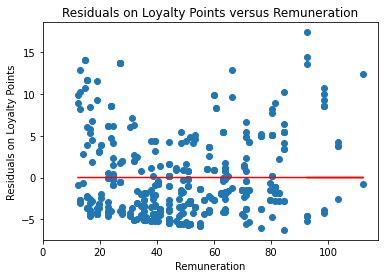

In [24]:
# Look at behaviour of residuals. There should be no pattern ideally.
mlr_resids = Y_pred-y
plt.scatter(remuneration, mlr_resids)
plt.plot(remuneration, y-y, color='red')

# Add axis labels
plt.xlim(0)
plt.title('Residuals on Loyalty Points versus Remuneration')
plt.xlabel('Remuneration')
plt.ylabel('Residuals on Loyalty Points')

In [25]:
# Determine heteroscedasticity.
model = sms.het_breuschpagan(model.resid, model.model.exog)

terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
print(dict(zip(terms, model)))

{'LM stat': 3.213714003873669, 'LM Test p-value': 0.2005168487827793, 'F-stat': 1.6070720638060942, 'F-test p-value': 0.20079776478776248}


## 5. Clustering analysis on remuneration and spending scores.

The marketing department also wants to better understand the usefulness of renumeration and spending scores but do not know where to begin. Below analysis aims to identify groups within the customer base that can be used to target specific market segments. *k*-means clustering is used to identify the optimal number of clusters, which are then used to plot the data using the created segments.

The final model and output consists of 5 distinct clusters. This has been validated through various means:
- Visually through the initial pairplot, the presence of 5 clusters is suspected as there seem to be 5 differnet groupings of 'dots'.
- The "elbow" method shows a visually significant change after 5 clusters in the graph.
- The silhouette score peaks at exactly 5 clusters.
- The size of the clusters, besides the larger cluster 0, is fairly uniform across the other 4. This worsens when adding or removing clusters, which has been tested.

Tests have been run with both 4 and 6 clusters, and this code can be easily adapted (n_clusters) to rerun the models. Nevertheless these tests only reaffirmed the notion that 5 clusters is optimal.

More on the findings and conclusions from the k-means analysis can be found in the accompanying document/video in the GitHub repository.

In [26]:
# Prepare the dataframe for k-means analysis
reviews_k = reviews[['remuneration','spending_score']]

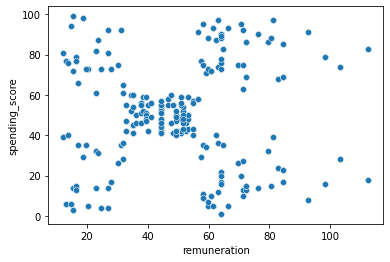

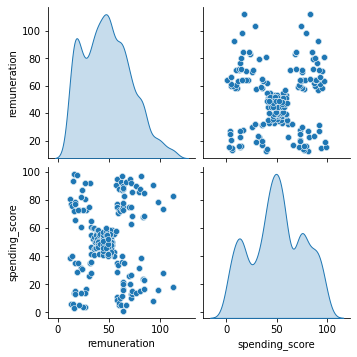

In [27]:
# Create a scatterplot with Seaborn to get a first glimpse of possible clusters.
sns.scatterplot(x='remuneration',
                y='spending_score',
                data=reviews_k)


# Create a pairplot with Seaborn.
sns.pairplot(reviews_k,
             vars=reviews_k,
             diag_kind= 'kde')

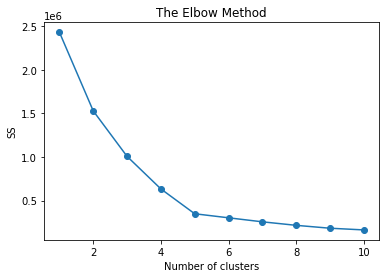

In [28]:
# Elbow chart for us to decide on the number of optimal clusters.
ss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i,
                    init = 'k-means++', 
                    max_iter = 500,
                    n_init = 10,
                    random_state = 42)
    kmeans.fit(reviews_k)
    ss.append(kmeans.inertia_)

plt.plot(range(1, 11),
         ss,
         marker='o')

plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("SS")

plt.show()

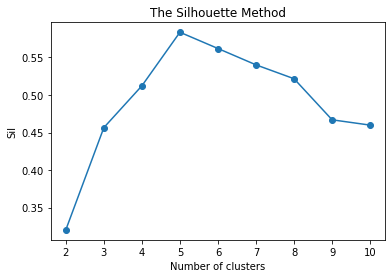

In [29]:
# Find the range of clusters to be used using silhouette method.
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans_s = KMeans(n_clusters = k).fit(reviews_k)
    labels = kmeans_s.labels_
    sil.append(silhouette_score(reviews_k,
                                labels,
                                metric = 'euclidean'))

# Plot the silhouette method.
plt.plot(range(2, kmax+1),
         sil,
         marker='o')

plt.title("The Silhouette Method")
plt.xlabel("Number of clusters")
plt.ylabel("Sil")

plt.show()

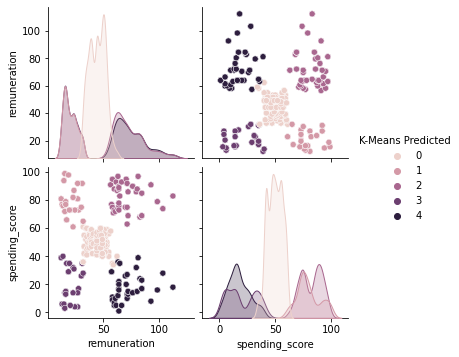

In [30]:
# Use 5 clusters (change n_clusters to run tests for different cluster numbers).
kmeans = KMeans(n_clusters = 5,
                max_iter = 15000,
                init='k-means++',
                random_state=42).fit(reviews_k)

clusters = kmeans.labels_
reviews_k['K-Means Predicted'] = clusters

# Plot the predicted clusters.
sns.pairplot(reviews_k,
             hue='K-Means Predicted',
             diag_kind= 'kde')

In [31]:
# Check the number of observations per predicted class.
print(reviews_k['K-Means Predicted'].value_counts())

# View the K-Means predicted.
print(reviews_k.head())

0    774
2    356
4    330
3    271
1    269
Name: K-Means Predicted, dtype: int64
   remuneration  spending_score  K-Means Predicted
0         12.30              39                  3
1         12.30              81                  1
2         13.12               6                  3
3         13.12              77                  1
4         13.94              40                  3


Text(0, 0.5, 'Spending Score')

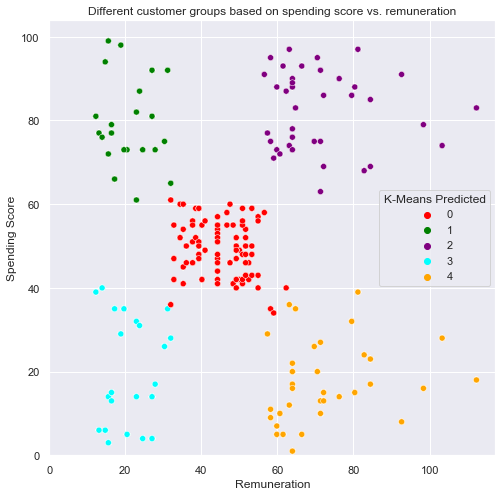

In [32]:
# Visualising the clusters.
sns.set(rc = {'figure.figsize':(8, 8)})

sns.scatterplot(x='remuneration', 
                y ='spending_score',
                data=reviews_k,
                hue='K-Means Predicted',
                palette=['red', 'green', 'purple', 'cyan', 'orange'])

# Add axis labels
plt.xlim(0)
plt.ylim(0)

plt.title('Different customer groups based on spending score vs. remuneration')
plt.xlabel('Remuneration')
plt.ylabel('Spending Score')

## 6. Understanding Customer sentiment through analysis of reviews.

Customer reviews were downloaded from the website of Turtle Games. This data will be used to steer the marketing department on how to approach future campaigns. A few key business questions were asked, which are answered by applying Natural Language Processing (NLP) on the data set:
- To identify the 15 most common words used in online product reviews
- A list of the top 20 positive and negative reviews received from the website. 

More on the findings and conclusions from the NLP analysis can be found in the accompanying document/video in the GitHub repository.

### 6.1 Prepare the data for sentiment analysis

A new dataframe is created with only the textual columns needed. No null values are confirmed once more.

In [33]:
# Retain the review and summary columns from original dataframe.
reviews_s_raw = reviews[['review','summary']]

# Sensecheck first rows.
reviews_s_raw.head()

# Confirmed no null values.
reviews_s_raw.info()
reviews_s_raw.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   review   2000 non-null   object
 1   summary  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


review     0
summary    0
dtype: int64

### 6.2 Prepare the data for the NLP model.
The string columns undergo several transformations to facilitate NLP:
- All words are transformed to lowercase.
- All punctuation is removed.
- The words in both columns are tokenized.
- Popular stopwords are removed to focus on relevant words only.

A perhaps interesting choice has been made to not remove any 'duplicate' lines. This was done after careful review of what actually counts as a duplicate in this context. Taking into account the business context in the scenario, it is likely that (especially shorter) genuine reviews and summaries could contain the same words. This was checked by isolating the duplicates, which contain such examples as "five stars"(summary) and "i love it"(review). Removing these has no added benefit for future analysis, and in fact would negatively distort the overall sentiment analysis as these rows contain crucial data for e.g. the polarity check. Therefore no duplicates have been removed.

In [34]:
# Transform data to lowercase.
reviews_s_lower = reviews_s_raw.applymap(lambda x: x.lower())
reviews_s_lower.head()

,review,summary
0,"when it comes to a dm's screen, the space on t...",the fact that 50% of this space is wasted on a...
1,an open letter to galeforce9*:\n\nyour unpaint...,another worthless dungeon master's screen from...
2,"nice art, nice printing. why two panels are f...","pretty, but also pretty useless"
3,amazing buy! bought it as a gift for our new d...,five stars
4,as my review of gf9's previous screens these w...,money trap


In [35]:
# Replace punctuation in each of the columns.
reviews_s_punct = reviews_s_lower.applymap(lambda x: re.sub(r'[^\w\s]','',x))
reviews_s_punct.head(5)

,review,summary
0,when it comes to a dms screen the space on the...,the fact that 50 of this space is wasted on ar...
1,an open letter to galeforce9\n\nyour unpainted...,another worthless dungeon masters screen from ...
2,nice art nice printing why two panels are fil...,pretty but also pretty useless
3,amazing buy bought it as a gift for our new dm...,five stars
4,as my review of gf9s previous screens these we...,money trap


In [36]:
# Review duplicates in both columns.
# Note: after review, it was chosen not to remove duplicates as they appear genuine and removing them will distort overall sentiment analysis findings.
print("Total number of duplicate rows:",reviews_s_punct.duplicated().sum())
dupe_review = reviews_s_punct[reviews_s_punct.duplicated(['review'], keep=False)]
dupe_summary = reviews_s_punct[reviews_s_punct.duplicated(['summary'], keep=False)]
print(dupe_review.head())
print(dupe_summary.head())

Total number of duplicate rows: 39
          review     summary
43     i love it  five stars
48       love it  five stars
55         great  five stars
65     very cute   very cute
78  good product  five stars
                                               review     summary
3   amazing buy bought it as a gift for our new dm...  five stars
5                                      grandson loves  five stars
7                           came in perfect condition  five stars
10                                    works very well  five stars
15                        very fun game for my family  five stars


In [37]:
# If wish to use deduplication, use code below.
# reviews_s_dedup = reviews_s_punct.drop_duplicates(['review','summary'],keep= 'last')
# print("Number of duplicate reviews before cleansing:",reviews_s_dedup['review'].duplicated().sum())
# print("Number of duplicate summaries before cleansing:",reviews_s_dedup['summary'].duplicated().sum())

In [38]:
# Tokenise the words and check outcome.
reviews_tokens = reviews_s_punct
reviews_tokens['summary_tokens'] = reviews_tokens['summary'].apply(word_tokenize)
reviews_tokens['review_tokens'] = reviews_tokens['review'].apply(word_tokenize)

# Preview data.
print(reviews_tokens['summary_tokens'].head())
print(reviews_tokens['review_tokens'].head())

0    [the, fact, that, 50, of, this, space, is, was...
1    [another, worthless, dungeon, masters, screen,...
2                 [pretty, but, also, pretty, useless]
3                                        [five, stars]
4                                        [money, trap]
Name: summary_tokens, dtype: object
0    [when, it, comes, to, a, dms, screen, the, spa...
1    [an, open, letter, to, galeforce9, your, unpai...
2    [nice, art, nice, printing, why, two, panels, ...
3    [amazing, buy, bought, it, as, a, gift, for, o...
4    [as, my, review, of, gf9s, previous, screens, ...
Name: review_tokens, dtype: object


In [39]:
# Create single list of tokens per column to prepare for further analysis.
# Define emtpy lists of tokens.
summary_tokens_list = []
review_tokens_list = []

for i in range(reviews_tokens.shape[0]):
    # Add each token to the list.
    summary_tokens_list = summary_tokens_list + reviews_tokens['summary_tokens'][i]

for i in range(reviews_tokens.shape[0]):
    # Add each token to the list.
    review_tokens_list = review_tokens_list + reviews_tokens['review_tokens'][i]

print(summary_tokens_list[0:5])
print(review_tokens_list[0:5])

['the', 'fact', 'that', '50', 'of']
['when', 'it', 'comes', 'to', 'a']


In [40]:
# Download the stop word list.
nltk.download ('stopwords')

# Create a set of English stop words (all reviews are in English).
english_stopwords = set(stopwords.words('english'))

# Create a filtered list of tokens without English stop words and preview outcome.
summary_clean_list = [x for x in summary_tokens_list if x not in english_stopwords]
review_clean_list = [x for x in review_tokens_list if x not in english_stopwords]
print("Final summary list length:",len(summary_clean_list))
print("First summary list values:",summary_clean_list[0:5])
print("Final review list length:",len(review_clean_list))
print("First review list values:",review_clean_list[0:5])

Final summary list length: 6216
First summary list values: ['fact', '50', 'space', 'wasted', 'art']
Final review list length: 57729
First review list values: ['comes', 'dms', 'screen', 'space', 'screen']


[nltk_data] Downloading package stopwords to /Users/gavin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Define an empty string variable to prepare for wordcloud.
summary_string = ''
review_string = ''

for value in summary_clean_list:
    # Add each filtered token word to the string.
    summary_string = summary_string + value + ' '
    
for value in review_clean_list:
    # Add each filtered token word to the string.
    review_string = review_string + value + ' '

## 6.3: Create word clouds and top frequency charts for reviews and summaries.
The wordclouds below mostly provided a neat visual glimpse into the frequently used words in the reviews and summaries. Overall it seems that there is a majority of positive words present in the data set, and the frequency charts seem to confirm this. The upcoming sentiment analysis will add another view on this data.

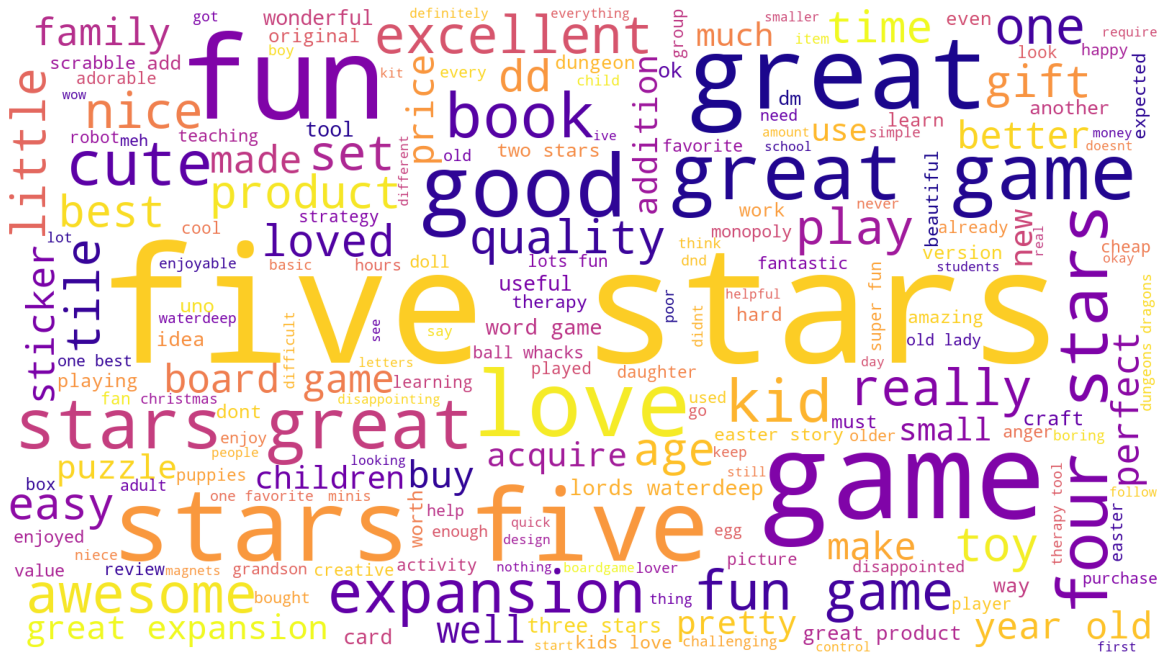

In [42]:
# Create a WordCloud for the summary column.
from wordcloud import WordCloud 

wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(summary_string) 

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

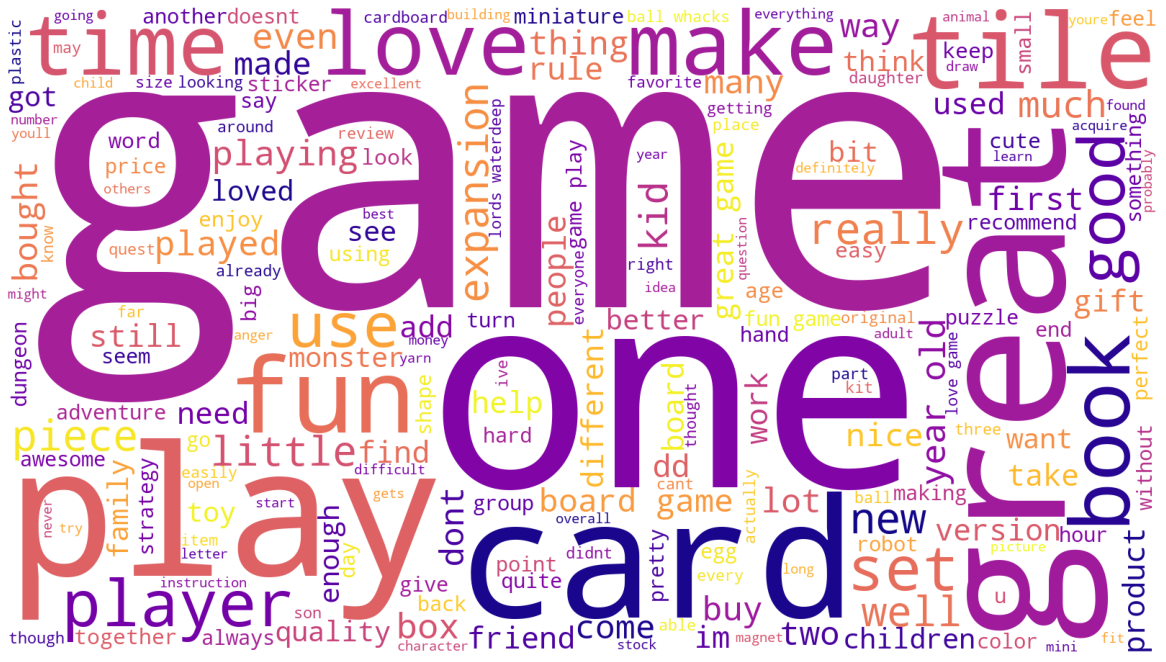

In [43]:
# Create a WordCloud for the review column.
wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(review_string) 

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

In [44]:
# Count the most common words in the review column.
review_counts = pd.DataFrame(Counter(review_clean_list).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')

# Count the most common words in the summary column.
summary_counts = pd.DataFrame(Counter(summary_clean_list).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')

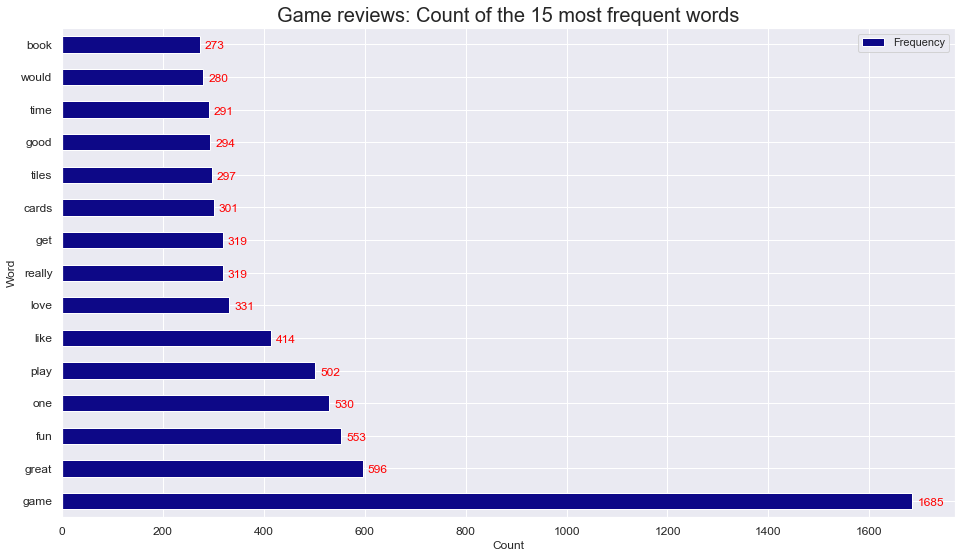

In [45]:
# Present the findings in a plot: reviews.
# Set the plot type.
ax = review_counts.plot(kind='barh', figsize=(16, 9), fontsize=12,
                 colormap ='plasma')

# Set the labels.
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Word', fontsize=12)
ax.set_title("Game reviews: Count of the 15 most frequent words",
             fontsize=20)

# Draw the bar labels.
for i in ax.patches:
    ax.text(i.get_width()+10, i.get_y()+0.1, str(round((i.get_width()), 2)),
            fontsize=12, color='red')

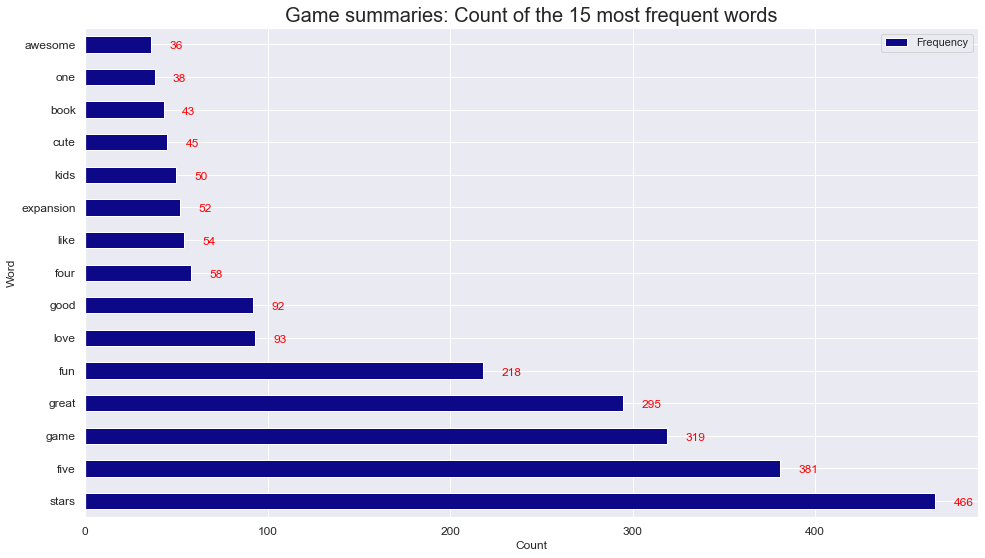

In [46]:
# Present the findings in a plot: summaries. 
# Set the plot type.
ax = summary_counts.plot(kind='barh', figsize=(16, 9), fontsize=12,
                 colormap ='plasma')

# Set the labels.
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Word', fontsize=12)
ax.set_title("Game summaries: Count of the 15 most frequent words",
             fontsize=20)

# Draw the bar labels.
for i in ax.patches:
    ax.text(i.get_width()+10, i.get_y()+0.1, str(round((i.get_width()), 2)),
            fontsize=12, color='red')

## 6.4: Review polarity and sentiment for reviews and summaries.
Both the polarity of the 15 most frequently used words, as well as the polarity scores of the overall columns (including means > 0) show that overall the sentiment is positive. Of course a bit of caution would be wise, as words such as "one" are marked as neutral, where it could refer to a "one star review". The same would go for "five" or other more positive numbers that appear frequently, the overall conclusion still is that customer sentiment is positive.

In [47]:
# Calculate sentiment polarity for top 15 words across summaries & reviews.
review_counts_pol = review_counts.reset_index()
summary_counts_pol = summary_counts.reset_index()

# Define a function to extract a polarity score for the words.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

# Populate a new column with polarity scores for each comment.
review_counts_pol['polarity'] = review_counts_pol['Word'].apply(generate_polarity)
summary_counts_pol['polarity'] = summary_counts_pol['Word'].apply(generate_polarity)

# Review results.
print(review_counts_pol.head(15))
print(summary_counts_pol.head(15))

      Word  Frequency  polarity
0     game       1685      -0.4
1    great        596       0.8
2      fun        553       0.3
3      one        530       0.0
4     play        502       0.0
5     like        414       0.0
6     love        331       0.5
7   really        319       0.2
8      get        319       0.0
9    cards        301       0.0
10   tiles        297       0.0
11    good        294       0.7
12    time        291       0.0
13   would        280       0.0
14    book        273       0.0
         Word  Frequency  polarity
0       stars        466       0.0
1        five        381       0.0
2        game        319      -0.4
3       great        295       0.8
4         fun        218       0.3
5        love         93       0.5
6        good         92       0.7
7        four         58       0.0
8        like         54       0.0
9   expansion         52       0.0
10       kids         50       0.0
11       cute         45       0.5
12       book         43       0.

In [48]:
# Populate a new column with polarity scores for each comment.
reviews_s_punct['review_polarity'] = reviews_s_punct['review'].apply(generate_polarity)
reviews_s_punct['summary_polarity'] = reviews_s_punct['summary'].apply(generate_polarity)

# Compare means, min and max of two columns. This clearly shows the data sets lean towards positive overall.
print(reviews_s_punct.describe())

       review_polarity  summary_polarity
count      2000.000000       2000.000000
mean          0.217688          0.219317
std           0.262502          0.335627
min          -1.000000         -1.000000
25%           0.049888          0.000000
50%           0.182258          0.062500
75%           0.361028          0.451250
max           1.000000          1.000000


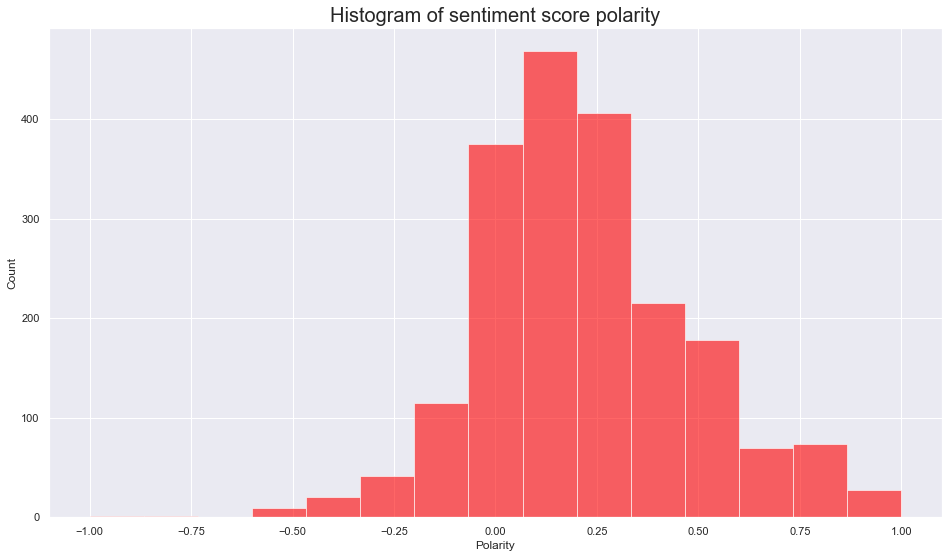

In [49]:
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(16,9))

# Define the bars.
n, bins, patches = plt.hist(reviews_s_punct['review_polarity'], num_bins, facecolor='red', alpha=0.6)

# Set the labels.
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of sentiment score polarity', fontsize=20)

plt.show()

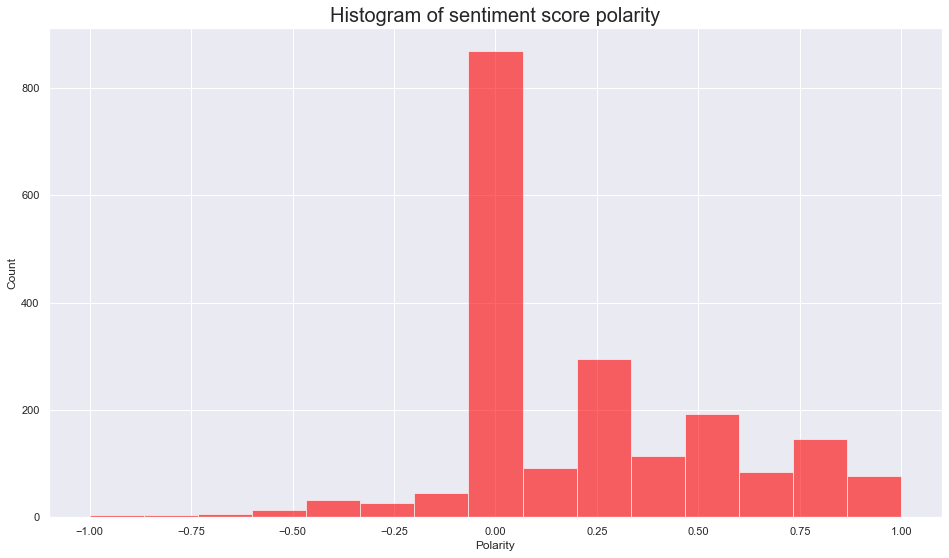

In [50]:
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(16,9))

# Define the bars.
n, bins, patches = plt.hist(reviews_s_punct['summary_polarity'], num_bins, facecolor='red', alpha=0.6)

# Set the labels.
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of sentiment score polarity', fontsize=20)

plt.show()

## 6.5 Identify top 20 positive and negative reviews and summaries.
For simplicty sake, it was chosen here to add up the polarity scores for reviews and summaries (for the same review) to get a "total polarity" score. Looking at these reviews gives interesting insights which will be further discussed in the accompanying video presentation and PDF document, found in the GitHub repository.

In [51]:
reviews_pol = reviews_s_punct[['review','summary','review_polarity','summary_polarity']]
reviews_pol['total_polarity'] = reviews_s_punct['summary_polarity'] + reviews_s_punct['review_polarity']

# Create a DataFrame for positive sentiment.
positive_sentiment = reviews_pol.nlargest(20, 'total_polarity')

# Adjust the column width.
positive_sentiment.style.set_properties(subset=['review'], **{'width': '600px'})

,review,summary,review_polarity,summary_polarity,total_polarity
1550,my daughter loves her stickers awesome seller thank you,awesome seller thank you,1.000000,1.000000,2.000000
1245,the best part i see is the box what a wonderfully diverse and rounded set for the cost i am so happy and as the dm you know that if i am happy my players are happy,excellent tile set,0.880000,1.000000,1.880000
418,great resource for bhis care coordinators works well with kids and teens on what it says it does,perfect,0.800000,1.000000,1.800000
32,awesome my 8 year olds favorite xmas gift its 915 am xmas morning and hes already colored three of these,perfect,0.750000,1.000000,1.750000
1543,grand daughter loves stickers and she loves peppa so this was perfect,loves stickers and she loves peppa so this was perfect,0.750000,1.000000,1.750000
6,i have bought many gm screens over the years but this one is the best i have ever seen it has all the relevant information i need and no crap filler on it very happy with this screen,best gm screen ever,0.660000,1.000000,1.660000
703,great quality very cute and perfect for my toddler,great quality very cute and perfect for my toddler,0.816667,0.816667,1.633333
36,the pictures are great ive done one and gave it to a friend of mine who likes dragons,the pictures are great ive done one and gave it to a,0.800000,0.800000,1.600000
474,great seller happy with my purchase 5 starrrr,great for kids,0.800000,0.800000,1.600000
620,great easter gift for kids,great easter gift for kids,0.800000,0.800000,1.600000


In [52]:
# Create a DataFrame for negative sentiment.
negative_sentiment = reviews_pol.nsmallest(20, 'total_polarity')

# Eliminate unnecessary columns.
negative_sentiment.style.set_properties(subset=['review'], **{'width': '500px'})

,review,summary,review_polarity,summary_polarity,total_polarity
208,booo unles you are patient know how to measure i didnt have the patience neither did my daughter boring unless you are a craft person which i am not,boring unless you are a craft person which i am,-1.000000,-1.000000,-2.000000
1804,im sorry i just find this product to be boring and to be frank juvenile,disappointing,-0.583333,-0.600000,-1.183333
364,one of my staff will be using this game soon so i dont know how well it works as yet but after looking at the cards i believe it will be helpful in getting a conversation started regarding anger and what to do to control it,anger control game,-0.550000,-0.550000,-1.100000
1166,before this i hated running any rpg campaign dealing with towns because it kills the momentum and just becomes 2 hours of haggling for magic items this helps open up story ideas and plot hooks,before this i hated running any rpg campaign dealing with towns because it,-0.133333,-0.900000,-1.033333
1003,if you play dungeons and dragons then you will find this board game to be dumb and boring stick with the real thing,then you will find this board game to be dumb and boring,-0.393750,-0.591667,-0.985417
1620,i was thinking it was a puppet but it is not it is a doll still worked for what i needed but the only way to get the animals in and out is through the mouth which is a little difficult for a little child,disappointed,-0.218750,-0.750000,-0.968750
21,these are cute tatoos for those who love pirates however the retail price is 150 and amazons price is more than double i have never paid over the retail price for an item at amazon i was shocked there are only a handful of tatoos and for 150 i wouldnt mind but to charge 350 for an item that sells anywhere else for 150 is criminal find it at a local drugstore and save your,the worst value ive ever seen,0.050000,-1.000000,-0.950000
178,at age 31 i found these very difficult to make i cant imagine how an 8 year old would do it by themselves,at age 31 i found these very difficult to make,-0.275000,-0.650000,-0.925000
890,the game tiles board and tile stands are all made of paper after using few times it will not sustain paper board tiles will move on the board making the game messy and inconvenient to manage its a shame what they have done to such a brilliant game,bad qualityall made of paper,-0.162500,-0.700000,-0.862500
829,ive discovered that im really new school when it comes to my board games except for boggle and a couple chess boards and a novelty version of yahtzee this is the oldest game i own by more than 30 years its very watered down for my usual tastes gameplay consists of playing tiles on a board to start expand or merge hotel chains then you buy stocks trying to predict which ones will grow so you can buy as low as possible and sell them for huge profits by the end of the game the player with the most money at the end wins i think this game is certainly better with more people it can accommodate up to 6 and that may be too many ive never played with that number but with 3 or fewer it is too easy to run away with the game more players offers more competition and gaps between your turns and dilutes the available stock with three you can see what tiles you have available and buy up huge amounts of stock early before other players have time to react and attempt to thwart your plan or prevent you from a big payout ive enjoyed power grid and have intended on playing a deeper economic game for some time but this certainly isnt it this is much more shallow an experience although it does play reasonably quickly and may fill a shorter time slot if players are looking for a quick buy and sell stock game,boring,0.156399,-1.000000,-0.843601


### 7: Summary and conclusion

For further context and a detailed report related to the findings in this Notebook, as well as the R-script used for the remaing business questions, please refer to the PDF document and video link in the GitHub repository.